## Preprocessing

In [1]:
with open("task/train.txt") as file:
    data = file.read()
    train_ids=data.split()
with open("task/valid.txt") as file:
    data = file.read()
    test_ids=data.split()

In [2]:
from PIL import Image

def get_image(img_id):
    image = Image.open(f'images/{img_id}.jpg')
    return image

In [3]:
from xml.dom import minidom
def get_svg_polygons(img_id):
    #source: https://stackoverflow.com/a/15857847
    doc = minidom.parse(f'ground-truth/locations/{img_id}.svg')
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    doc.unlink()
    polygons=[]
    for path_string in path_strings:
        splitted_path_string=path_string.split()
        temp_coor=[]
        polygons.append([])
        for i in range(len(splitted_path_string)):
            if i%3==0 and i!=0:
                polygons[-1].append(tuple(temp_coor))
                temp_coor=[]
            elif i!=0:
                temp_coor.append(float(splitted_path_string[i]))
        
    return polygons

In [4]:
#source: https://stackoverflow.com/a/59208291
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image<255)
    image = Image.fromarray(image, "RGB")
    return image.crop((np.min(x_nonzero), np.min(y_nonzero), np.max(x_nonzero), np.max(y_nonzero)))

In [5]:
import numpy as np
from PIL import ImageDraw
from IPython.display import display
import cv2

def get_binarized_words(img_id):
    polygons=get_svg_polygons(img_id)

    im=get_image(img_id).convert("RGB")
    imArray = np.asarray(im)
    
    binarized_words=[]

    for polygon in polygons:
        #source: https://stackoverflow.com/a/22650239

        maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
        ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
        mask = np.array(maskIm)
        newImArray = np.empty(imArray.shape,dtype='uint8')

        newImArray[:,:,:3] = imArray[:,:,:3]

        newImArray[:,:,0] = np.invert(newImArray[:,:,0])
        newImArray[:,:,1] = np.invert(newImArray[:,:,1])
        newImArray[:,:,2] = np.invert(newImArray[:,:,2])

        newImArray[:,:,0] = newImArray[:,:,0] * mask
        newImArray[:,:,1] = newImArray[:,:,1] * mask
        newImArray[:,:,2] = newImArray[:,:,2] * mask

        newImArray[:,:,0] = np.invert(newImArray[:,:,0])
        newImArray[:,:,1] = np.invert(newImArray[:,:,1])
        newImArray[:,:,2] = np.invert(newImArray[:,:,2])

        newIm=crop(newImArray)

        img = np.array(newIm)
        img = img[:, :, ::-1].copy() 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        blur = cv2.GaussianBlur(img,(5,5),0)

        _,bin_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binarized_words.append(Image.fromarray(bin_img))

    return binarized_words



In [6]:
import random
train_id=random.choice(train_ids)

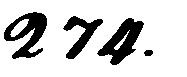

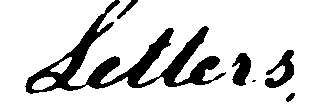

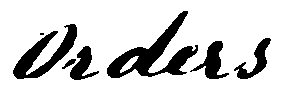

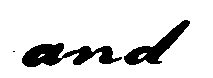

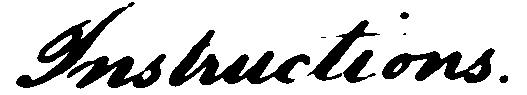

In [7]:
binarized_imgs = get_binarized_words(train_id)

for img in binarized_imgs[:5]:
    display(img)

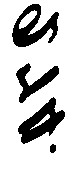

In [24]:
# transpose the images so they we can iterate over the array as a sliding window
transposed_imgs = [np.transpose(np.array(img)) for img in binarized_imgs]
display(Image.fromarray(transposed_imgs[0]))

In [95]:
import numpy as np

def n_transitions(img):
    n = 0
    for row in img:
        current = row[0]
        for pixel in row[1:]:
            if pixel != current:
                n += 1
                current = pixel
    return n


def upper_contour(img):
    """
    Return an index vector per column (IE window) in the image of the upper contour
    """
    cnt_indices = []
    for row in img:
        row_index = np.argmin(row)
        if row[row_index] != 0:
            cnt_indices.append(-1)
        else:
            cnt_indices.append(row_index)
    
        
    return cnt_indices

def lower_contour(img):
    # flip the img along the pixel rows axis 
    flipped = np.flip(img, axis=1)
    
    # when flipped, upper_contour will return the contour of the pixel rows sorted in inverse order
    reversed_contour = upper_contour(flipped)
    row_size = img.shape[0]
        
    for i in range(row_size):
        if reversed_contour[i] != -1:
            reversed_contour[i] = row_size - reversed_contour[i]
        
    return reversed_contour

def ratio_black_pixels(img):
    zeros = np.where(img==0)
    img_size = img.shape[0] * img.shape[1]
    return len(zeros[0]) / img_size

0.1672189349112426


In [98]:
from PIL import Image

features_dict = {
    'transitions':n_transitions,
    'upper_contour':upper_contour,
    'lower_contour':lower_contour,
    'ratio_black_pixels':ratio_black_pixels,
}


feature_vectors_dict = {}


for label, func in features_dict.items():
    feature_vec = []
    for img in transposed_imgs:
        feature_vec.append(func(img))
    
    feature_vectors_dict[label] = feature_vec
    
print(feature_vectors_dict['ratio_black_pixels'])


[0.18348496423362734, 0.1672189349112426, 0.17733103017383953, 0.13259901288070303, 0.1980025966243883, 0.21328448550493787, 0.287175234936429, 0.13978378378378378, 0.08966565349544073, 0.09991809991809991, 0.13039940828402366, 0.11554512847120395, 0.10732562020246969, 0.06281455671699575, 0.12692307692307692, 0.11321199865183687, 0.0772130211307824, 0.0589622641509434, 0.09164275466284075, 0.12104492737304358, 0.10917440252814536, 0.10387688665285587, 0.10758724256292906, 0.16046353101567826, 0.8411269001982815, 0.12320983810709839, 0.10862068965517241, 0.07855046057293248, 0.08399215026633025, 0.1406273831918247, 0.094039783264846, 0.06560773480662983, 0.09884209087536368, 0.0580041105275177, 0.07810421286031043, 0.07665805340223945, 0.12292767201568158, 0.04440759167127326, 0.0975424439320897, 0.08144329896907217, 0.08401570728440534, 0.08720777515103756, 0.09727361246348588, 0.11958041958041958, 0.10371613521937185, 0.07287131107885825, 0.06373626373626373, 0.05227743271221532, 0.